In [1]:
from tensorflow.keras.datasets import fashion_mnist
import tensorflow as tf
import matplotlib.pyplot as plt

(data_train, label_train), (data_test, label_test) = fashion_mnist.load_data()

data_train = data_train.astype('float32') / 255.
data_test = data_test.astype('float32') / 255.

data = tf.concat([data_train, data_test], axis= 0)
label = tf.concat([label_train, label_test], axis= 0)
print(label.shape)
print(data.shape)

(70000,)
(70000, 28, 28)


In [2]:
indices = tf.squeeze(tf.where(tf.logical_or(tf.equal(label, 4), tf.equal(label, 5))))
filtered_data = tf.gather(data, indices)
filtered_label = tf.gather(label, indices)

In [3]:
filtered_data.shape

TensorShape([14000, 28, 28])

In [4]:
filtered_label = tf.one_hot(filtered_label, depth=10)

In [5]:
from sklearn.model_selection import train_test_split

data_np = filtered_data.numpy()
label_np = filtered_label.numpy()
x_train, x_temp, y_train, y_temp = train_test_split(data_np, label_np, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
x_train.shape

(11200, 28, 28)

In [7]:
x_val.shape

(1400, 28, 28)

In [8]:
x_test.shape

(1400, 28, 28)

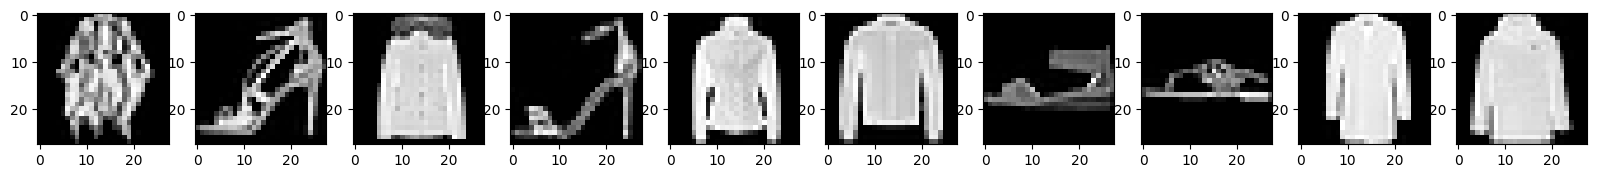

In [9]:
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].imshow(x_train[i], cmap='gray')

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.image import ssim

input_shape = (28, 28, 1)

# Encoder
encoder_input = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
latent = Dense(128, activation='relu', name='latent')(x)
encoder_model = Model(encoder_input, latent, name='encoder')
encoder_model.summary()

#Decoder
decoder_input = Input(shape=(128,), name='decoder_input')
x = Dense(6272, activation='relu')(decoder_input)
x = Reshape((14, 14, 32))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
decoded_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


decoder_model = Model(decoder_input, decoded_output, name='decoder')
decoder_model.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 latent (Dense)              (None, 128)               802944    
                                                                 
Total params: 803,264
Trainable params: 803,264
Non-trainable params: 0
_____________________________________________________

In [11]:
autoencoder_input = encoder_input
autoencoder_output = decoder_model(encoder_model(autoencoder_input))

In [12]:
model = Model(autoencoder_input, autoencoder_output, name='autoencoder')
model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 128)               803264    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         818625    
                                                                 
Total params: 1,621,889
Trainable params: 1,621,889
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.001), loss='binary_crossentropy')
model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 128)               803264    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         818625    
                                                                 
Total params: 1,621,889
Trainable params: 1,621,889
Non-trainable params: 0
_________________________________________________________________


c:\Users\srbol\anaconda3\envs\deep_learning\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [14]:
history = model.fit(x_train, x_train, batch_size = 16, epochs = 50, shuffle = True, validation_data = (x_val, x_val))


Epoch 1/50
700/700 [==============================] - 12s 7ms/step - loss: 0.2933 - val_loss: 0.2696
Epoch 2/50
700/700 [==============================] - 4s 5ms/step - loss: 0.2618 - val_loss: 0.2717
Epoch 3/50
700/700 [==============================] - 3s 5ms/step - loss: 0.2531 - val_loss: 0.2536
Epoch 4/50
700/700 [==============================] - 3s 5ms/step - loss: 0.2485 - val_loss: 0.2493
Epoch 5/50
700/700 [==============================] - 4s 5ms/step - loss: 0.2455 - val_loss: 0.2470
Epoch 6/50
700/700 [==============================] - 4s 5ms/step - loss: 0.2434 - val_loss: 0.2464
Epoch 7/50
700/700 [==============================] - 4s 5ms/step - loss: 0.2418 - val_loss: 0.2456
Epoch 8/50
700/700 [==============================] - 3s 5ms/step - loss: 0.2406 - val_loss: 0.2452
Epoch 9/50
700/700 [==============================] - 4s 5ms/step - loss: 0.2396 - val_loss: 0.2446
Epoch 10/50
700/700 [==============================] - 4s 5ms/step - loss: 0.2387 - val_loss: 0.242

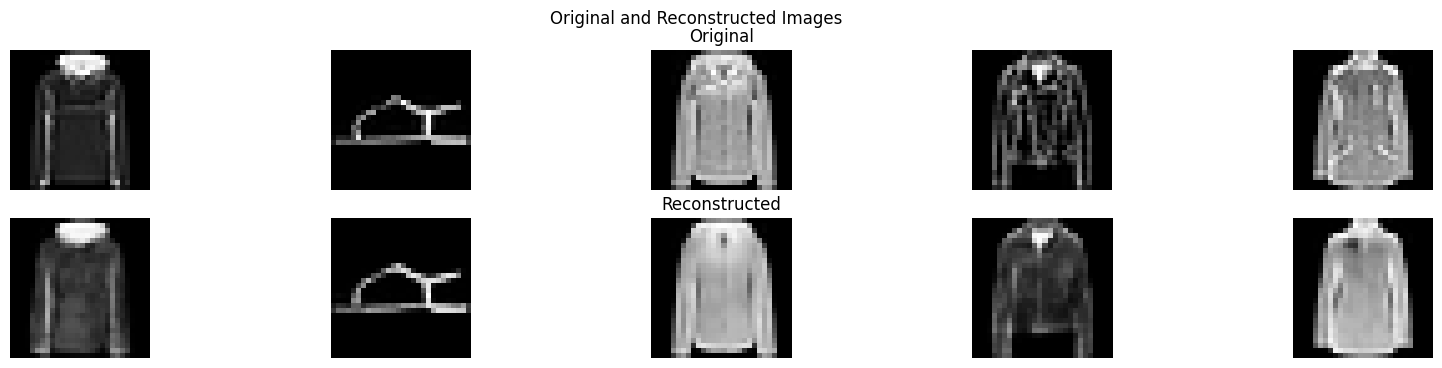

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Predict the reconstructed images
y_pred = model.predict(x_test)

# Number of images to display
num_images = 5

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(2, num_images, figsize=(20, 4))
fig.suptitle('Original and Reconstructed Images')

for i in range(num_images):
    # Original image
    ax = axes[0, i]
    # Convert EagerTensor to NumPy array before reshaping
    ax.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
    if i == num_images // 2:
        ax.set_title("Original")

    # Reconstructed image
    ax = axes[1, i]
    # Convert EagerTensor to NumPy array before reshaping
    ax.imshow(y_pred[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
    if i == num_images // 2:
        ax.set_title("Reconstructed")

plt.show()

Dari arsitektur baseline yang ada di model pertama ini bisa kita kalau model dengan arsitektur tersebut masih bisa dibilang overfit, namun memiliki hasil yang lumayan tinggi secara angka SSIM

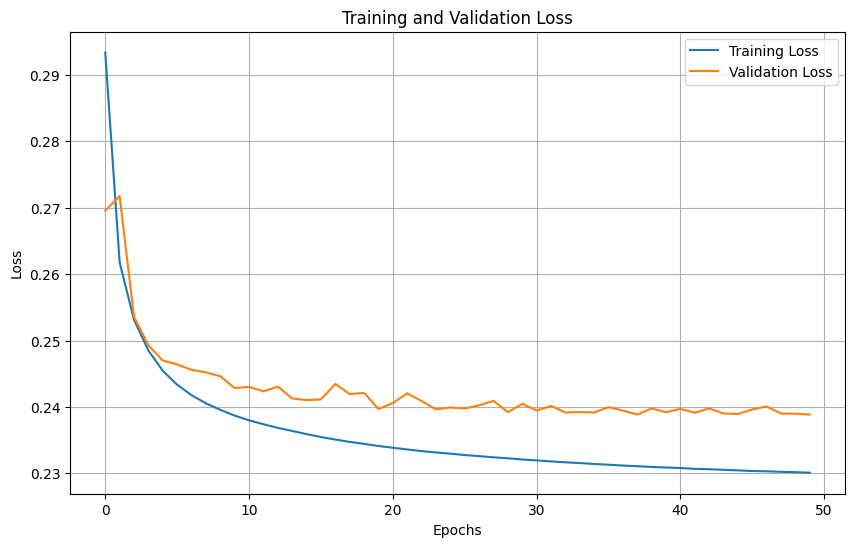

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
from skimage.metrics import structural_similarity

y_pred = model.predict(x_test)

print(f'SSIM : {structural_similarity(x_test.squeeze(), y_pred.squeeze())}')

SSIM : 0.9618072955801302
